In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [561]:
loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_lego_spheres_v5_clusters_100/cluster_24.npz") #24, 22, 20, 3, 19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']


In [535]:
loaded_data.keys

<bound method Mapping.keys of NpzFile '/home/dimakot55/output_data/gs_my/GT_lego_spheres_v5_clusters_100/cluster_24.npz' with keys: _xyz, _features_dc, _features_rest, _scaling, _rotation...>

In [537]:
gaussians_xyz.shape, gaussians_rotation.shape, gaussians_features_dc.shape

((2375, 3), (2375, 4), (2375, 1, 3))

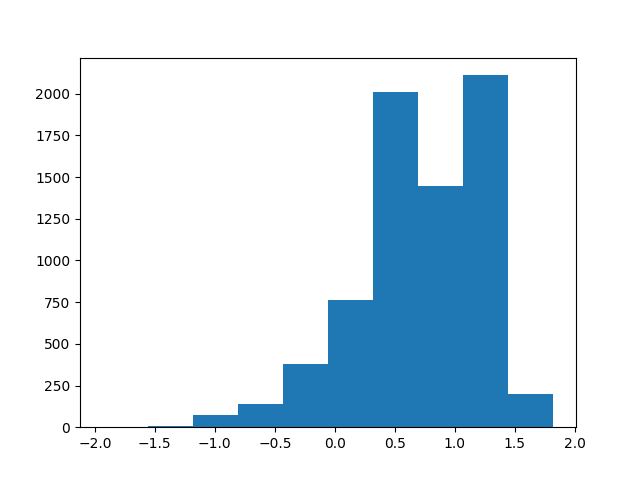

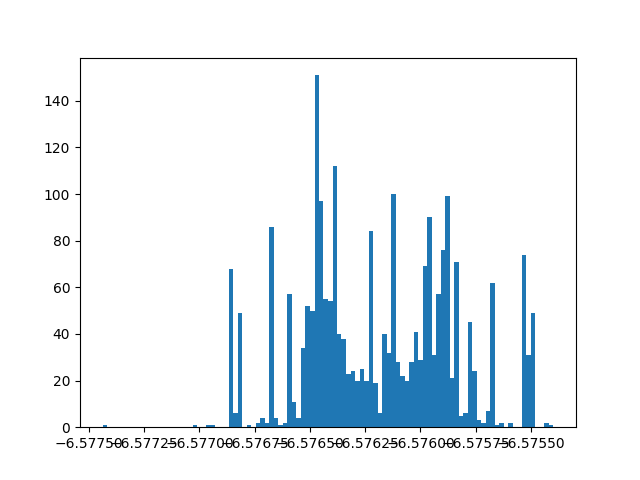

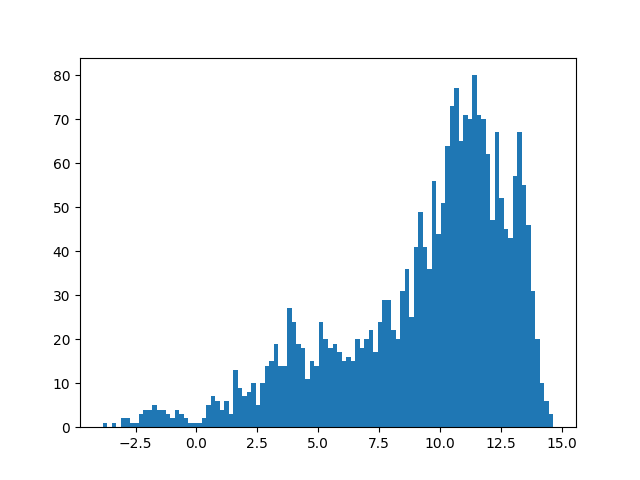

In [434]:
fig = plt.figure()
plt.hist(np.reshape(gaussians_features_dc,newshape=(-1)))
plt.show()
#plt.close()

fig = plt.figure()
plt.hist(np.reshape(gaussians_scaling[:,0],newshape=(-1)), bins=100)
plt.show()


fig = plt.figure()
plt.hist(np.reshape(gaussians_opacity,newshape=(-1)), bins=100)
plt.show()


#plt.close()

In [562]:
gaussians_scaling[:,0]

array([-6.5761175, -6.5766687, -6.5761275, ..., -6.5762343, -6.575954 ,
       -6.5760365], dtype=float32)

In [563]:
gaussians_opacity.shape

(2375, 1)

In [564]:
# remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')

# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)


In [565]:
kth_nearest_distances[0]

array([0.01084694, 0.00893414, 0.00560179, 0.01061505, 0.00932057,
       0.01209012, 0.00673733, 0.0136842 , 0.00768283, 0.00959817,
       0.01408641, 0.01076031, 0.00886838, 0.00956755, 0.01373911,
       0.01317317, 0.01402091, 0.00587321, 0.00627136, 0.01382044,
       0.00616621, 0.        , 0.00869062, 0.01372986, 0.00623525,
       0.00958814, 0.01089057, 0.01030548, 0.01436843, 0.0144681 ])

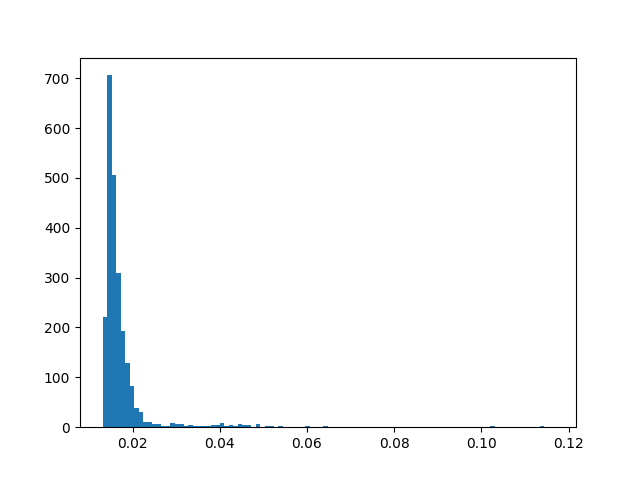

In [566]:
fig = plt.figure()
plt.hist(np.max(kth_nearest_distances, axis=-1), bins=100)
plt.show()

In [578]:
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)

idcs_relevant = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]

In [579]:
idcs_relevant

array([   0,    1,    5, ..., 2372, 2373, 2374])

In [580]:
gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

In [581]:
gaussians_xyz.shape, gaussians_rotation.shape, gaussians_features_dc.shape

((2196, 3), (2196, 4), (2196, 1, 3))

In [582]:
# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
# preprocess sizes. Remove 5 percent smallest sizes

sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)
#alpha = alpha > 1.


In [583]:
colors.shape, sizes.shape, alpha.shape

((2196, 3), (2196,), (2196,))

In [584]:
alpha

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [585]:
alpha[:,None].shape

(2196, 1)

In [586]:
np.concatenate([colors, alpha[:,None]], axis=-1)

array([[0.9086853 , 0.80491316, 0.61879224, 1.        ],
       [0.9187041 , 0.8303977 , 0.64528096, 1.        ],
       [0.8562274 , 0.7936899 , 0.65890944, 1.        ],
       ...,
       [0.84535116, 0.77967566, 0.6404158 , 1.        ],
       [0.85159767, 0.7864548 , 0.64577425, 1.        ],
       [0.80615807, 0.7534549 , 0.62719303, 1.        ]], dtype=float32)

Text(0.5, 0, 'Z Label')

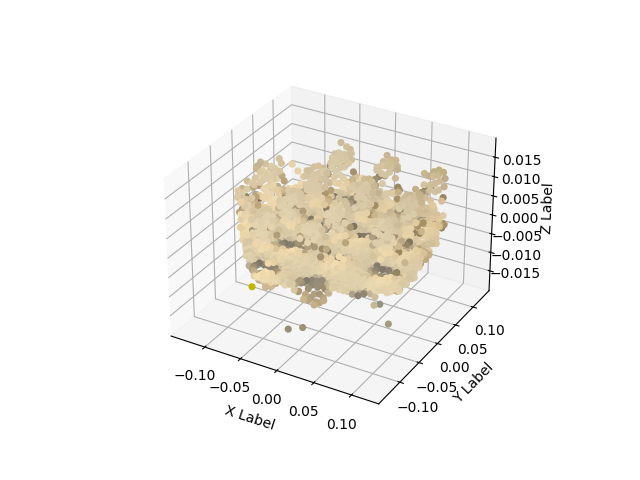

In [587]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

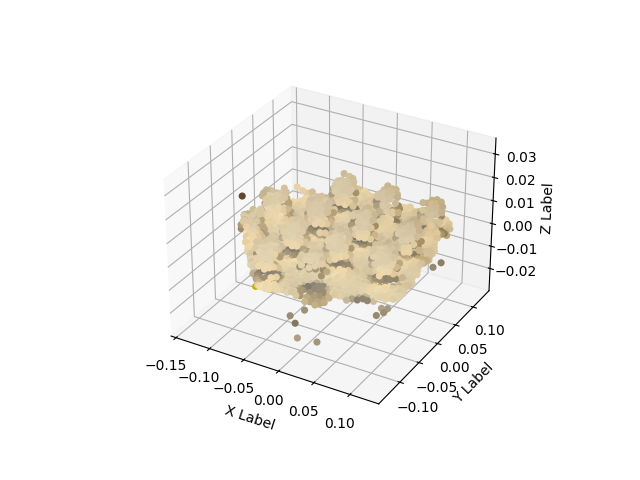

In [577]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

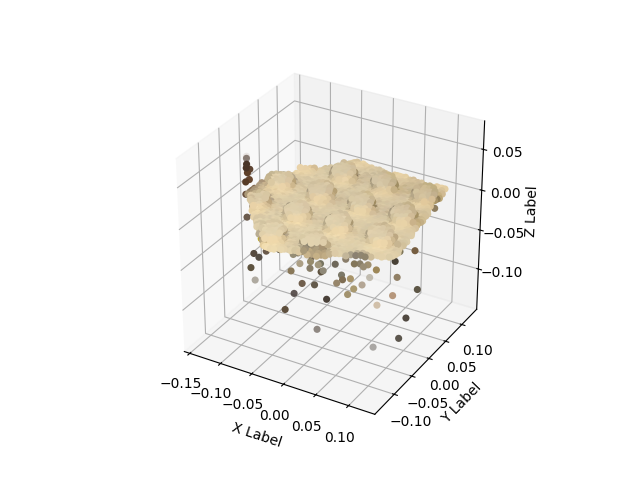

In [442]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [443]:
print("yo")

yo


# Optimization

## Aux functions computing descriptors

In [588]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_descriptors_vec(X, X_vec, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_vec: tensor or shape [N,l] that represents a vector assigned to every point from X. 
        can be of different dimensionality then X.
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        X_offsets_to_vec : tensor of shape [N, k,d] with pairwise offsets from the vector at the 
            query point to all the neighbors offsets.
    """
    
    X_nns = X[X_nns_indices]
    # Compute relative offsets from the curernt vector to all of its neighbors. 
    # also remove the root element
    #print("X_nns.shape:", X_nns.shape)
    #print("X_nns[:,0].unsqueeze(1).shape:", X_nns[:,0].unsqueeze(1).shape)
    X_nns_offsets = X_nns[:,1:] - X_nns[:,0].unsqueeze(1)
    # Now compute the differences from the vector to the offsets
    #X_offsets_to_vec = X_vec.unsqueeze(1) - X_nns_offsets
    # print("X_vec.unsqueeze(1):", X_vec.unsqueeze(1).shape)
    # print("X_nns_offsets:", X_nns_offsets.shape)

    # Old version
    # X_offsets_to_vec = torch.norm(X_vec.unsqueeze(1) - X_nns_offsets, dim=-1)
    # return X_offsets_to_vec
    # New version for arbitrary dimension
    
    # Another old version
    # X_offsets_to_vec = None
    # for i in range(l-d+1):
    #     if X_offsets_to_vec is not None:
    #         X_offsets_to_vec = torch.cat((X_offsets_to_vec, torch.norm(X_vec[...,i:i+d].unsqueeze(1) - X_nns_offsets, dim=-1)), dim=1)
    #     else:
    #         X_offsets_to_vec = torch.norm(X_vec[...,i:i+d].unsqueeze(1) - X_nns_offsets, dim=-1)
    subsets = [[0,1,2], [0,1,3], [0,2,3],[1,2,3]]
    X_offsets_to_vec=torch.cat([torch.norm(X_vec[...,subset].unsqueeze(1) - X_nns_offsets, dim=-1)  for subset in subsets], dim=1)
    #print("X_offsets_to_vec.shape:", X_offsets_to_vec.shape)
    return X_offsets_to_vec

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain

In [445]:
loaded_data_old = np.load("clusters.npz")

gaussians_shape_xyz = loaded_data_old['gaussians_shape_xyz']

In [593]:
device="cuda"
target_points_torch = torch.tensor(gaussians_xyz[alpha>0.5], device=device)
target_points_torch = torch.tensor(gaussians_xyz, device=device)
domain_points_torch = torch.tensor(loaded_data_old['gaussians_shape_xyz'], device=device) / torch.mean(torch.linalg.norm(target_points_torch))
# Old version with randomly initialized vector
points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) 

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 2000
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices)
print("target_descriptor_points.shape:", target_descriptor_points.shape)

# Now add even stronger local loss
num_nns = 100
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local)
print("target_descriptor_points.shape:", target_descriptor_points.shape)


optimizer = torch.optim.Adam([points_torch], lr=1e-1)

for iter in range(1001):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    
    descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local)
    loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
    
    loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
    
    loss = loss_points_local*2e0 + loss_points_local2*1e2 + loss_domain * 3e2
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")
        

target_descriptor_points.shape: torch.Size([2196, 1999])
target_descriptor_points.shape: torch.Size([2196, 1999])
loss_points_local:5.7733994, loss_points_local2:6.1676855, loss_domain:0.0101841
loss_points_local:0.0024626, loss_points_local2:0.0000687, loss_domain:0.0000845
loss_points_local:0.0009386, loss_points_local2:0.0000107, loss_domain:0.0000409
loss_points_local:0.0005402, loss_points_local2:0.0000058, loss_domain:0.0000197
loss_points_local:0.0003605, loss_points_local2:0.0000034, loss_domain:0.0000097
loss_points_local:0.0002418, loss_points_local2:0.0000024, loss_domain:0.0000057
loss_points_local:0.0001284, loss_points_local2:0.0000007, loss_domain:0.0000042
loss_points_local:0.0000730, loss_points_local2:0.0000005, loss_domain:0.0000032
loss_points_local:0.0000366, loss_points_local2:0.0000004, loss_domain:0.0000026
loss_points_local:0.0000194, loss_points_local2:0.0000003, loss_domain:0.0000021
loss_points_local:0.0000135, loss_points_local2:0.0000002, loss_domain:0.000

In [595]:


#optimizer = torch.optim.Adam([points_torch], lr=1e-1)

for iter in range(1001):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    
    descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local)
    loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
    
    loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
    
    loss = loss_points_local2*5e1 + loss_domain * 3e1
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")
        

loss_points_local:0.0000135, loss_points_local2:0.0000002, loss_domain:0.0000019
loss_points_local:0.0000132, loss_points_local2:0.0000001, loss_domain:0.0000018
loss_points_local:0.0000136, loss_points_local2:0.0000001, loss_domain:0.0000018
loss_points_local:0.0000139, loss_points_local2:0.0000001, loss_domain:0.0000018
loss_points_local:0.0000143, loss_points_local2:0.0000001, loss_domain:0.0000018
loss_points_local:0.0000146, loss_points_local2:0.0000001, loss_domain:0.0000018
loss_points_local:0.0000148, loss_points_local2:0.0000001, loss_domain:0.0000017
loss_points_local:0.0000150, loss_points_local2:0.0000001, loss_domain:0.0000017
loss_points_local:0.0000150, loss_points_local2:0.0000001, loss_domain:0.0000017
loss_points_local:0.0000150, loss_points_local2:0.0000001, loss_domain:0.0000017
loss_points_local:0.0000148, loss_points_local2:0.0000001, loss_domain:0.0000017


Text(0.5, 0, 'Z Label')

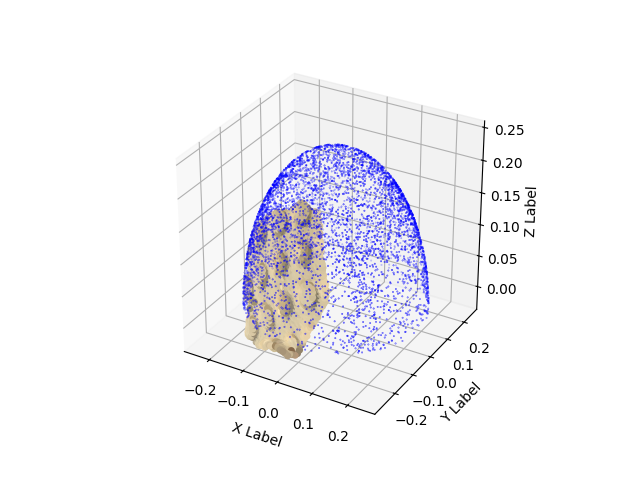

In [596]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

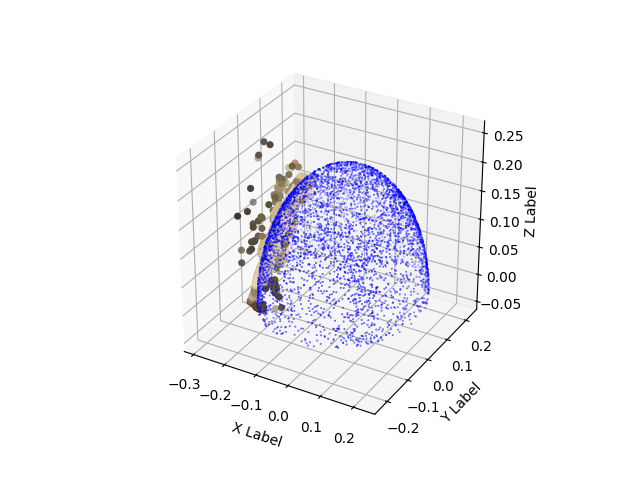

In [523]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

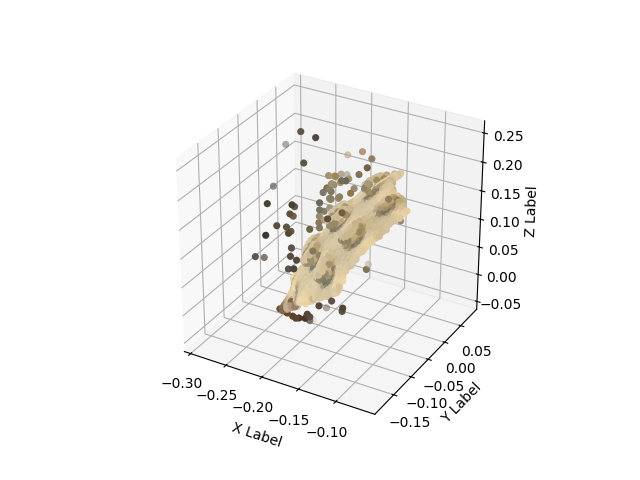

In [524]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
# arr_shape = domain_points_torch.detach().cpu().numpy()
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [525]:
## Save optimized model to scene

In [527]:
loaded_data['_features_rest']

array([[[-0.13315713, -0.10863838, -0.05576596],
        [-0.07802559, -0.06334021, -0.03884718],
        [-0.02800419, -0.05687862, -0.08058632],
        ...,
        [ 0.02123604,  0.00171422, -0.02394173],
        [-0.01811019, -0.02369796, -0.02743882],
        [ 0.09922621,  0.1302647 ,  0.13075355]],

       [[-0.2502859 , -0.2348308 , -0.19505183],
        [-0.11076591, -0.09516101, -0.07295351],
        [ 0.1132331 ,  0.08413976,  0.08096503],
        ...,
        [-0.09984148, -0.09842831, -0.11109252],
        [-0.05573343, -0.04887928, -0.04612632],
        [ 0.02113695,  0.04842702,  0.06672455]],

       [[-0.06823918, -0.07240754, -0.06764917],
        [-0.05765498, -0.04950523, -0.03471727],
        [ 0.1625988 ,  0.16809154,  0.12811941],
        ...,
        [ 0.01145386,  0.00056549, -0.0024475 ],
        [ 0.03820785,  0.02814875, -0.01842787],
        [-0.01134799,  0.00288933,  0.06772073]],

       ...,

       [[-0.00594063, -0.0088249 ,  0.01480922],
        [-0

In [598]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
#gaussians_to_save.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)



# gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
# gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
# gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
# gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
# gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
# gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# Store optimized parameters to the gaussias_to_save
gaussians_to_save._xyz = torch.tensor(points_torch.clone().detach())
gaussians_to_save._rotation = torch.tensor(gaussians_rotation)
gaussians_to_save._features_dc = torch.tensor(gaussians_features_dc)
gaussians_to_save._features_rest = torch.tensor(gaussians_features_rest*0.)
gaussians_to_save._scaling = torch.tensor(gaussians_scaling*0.885)
gaussians_to_save._opacity = torch.tensor(gaussians_opacity)


iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))



/tmp/ipykernel_706241/1609872077.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(points_torch.clone().detach())


Text(0.5, 0, 'Z Label')

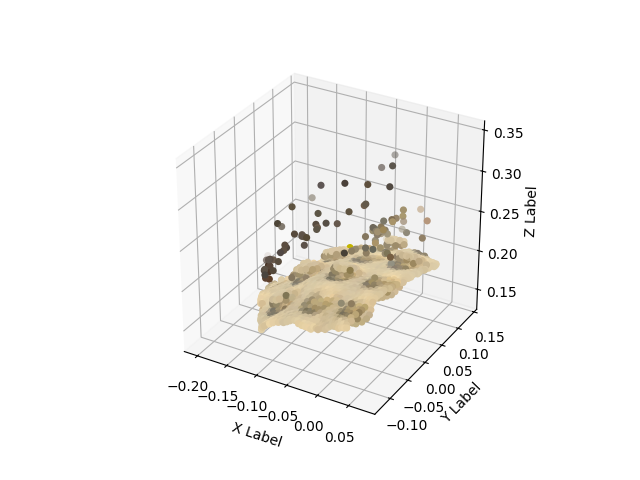

In [521]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
# arr_shape = domain_points_torch.detach().cpu().numpy()
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [ ]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')